# 1. Environment Setup

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Download the dataset form drive to local
!cp "/content/gdrive/MyDrive/Breast Cancer/breast_cancer_data.zip" .

!unzip -qq breast_cancer_data.zip
!rm breast_cancer_data.zip
cbis_path = 'breast_cancer'

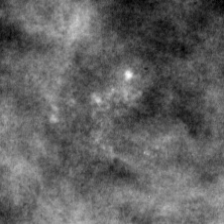

In [ ]:
import cv2
from google.colab.patches import cv2_imshow


image = cv2.imread("/content/jpeg/1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132/1-263.jpg")

image_resized = cv2.resize(image, (224, 224))

# Display the image using cv2_imshow
cv2_imshow(image_resized)


# 2. Dataset
- Taking a look a dataset

In [ ]:
 # check the amount of data
 import os
 jpg_files = []
 for root, dirs, files in os.walk("/content/jpeg"):
        jpg_files.extend([os.path.join(root, f) for f in files if f.lower().endswith('.jpg')])

print('Total no. of images:',len(jpg_files))


Total no. of images: 10237


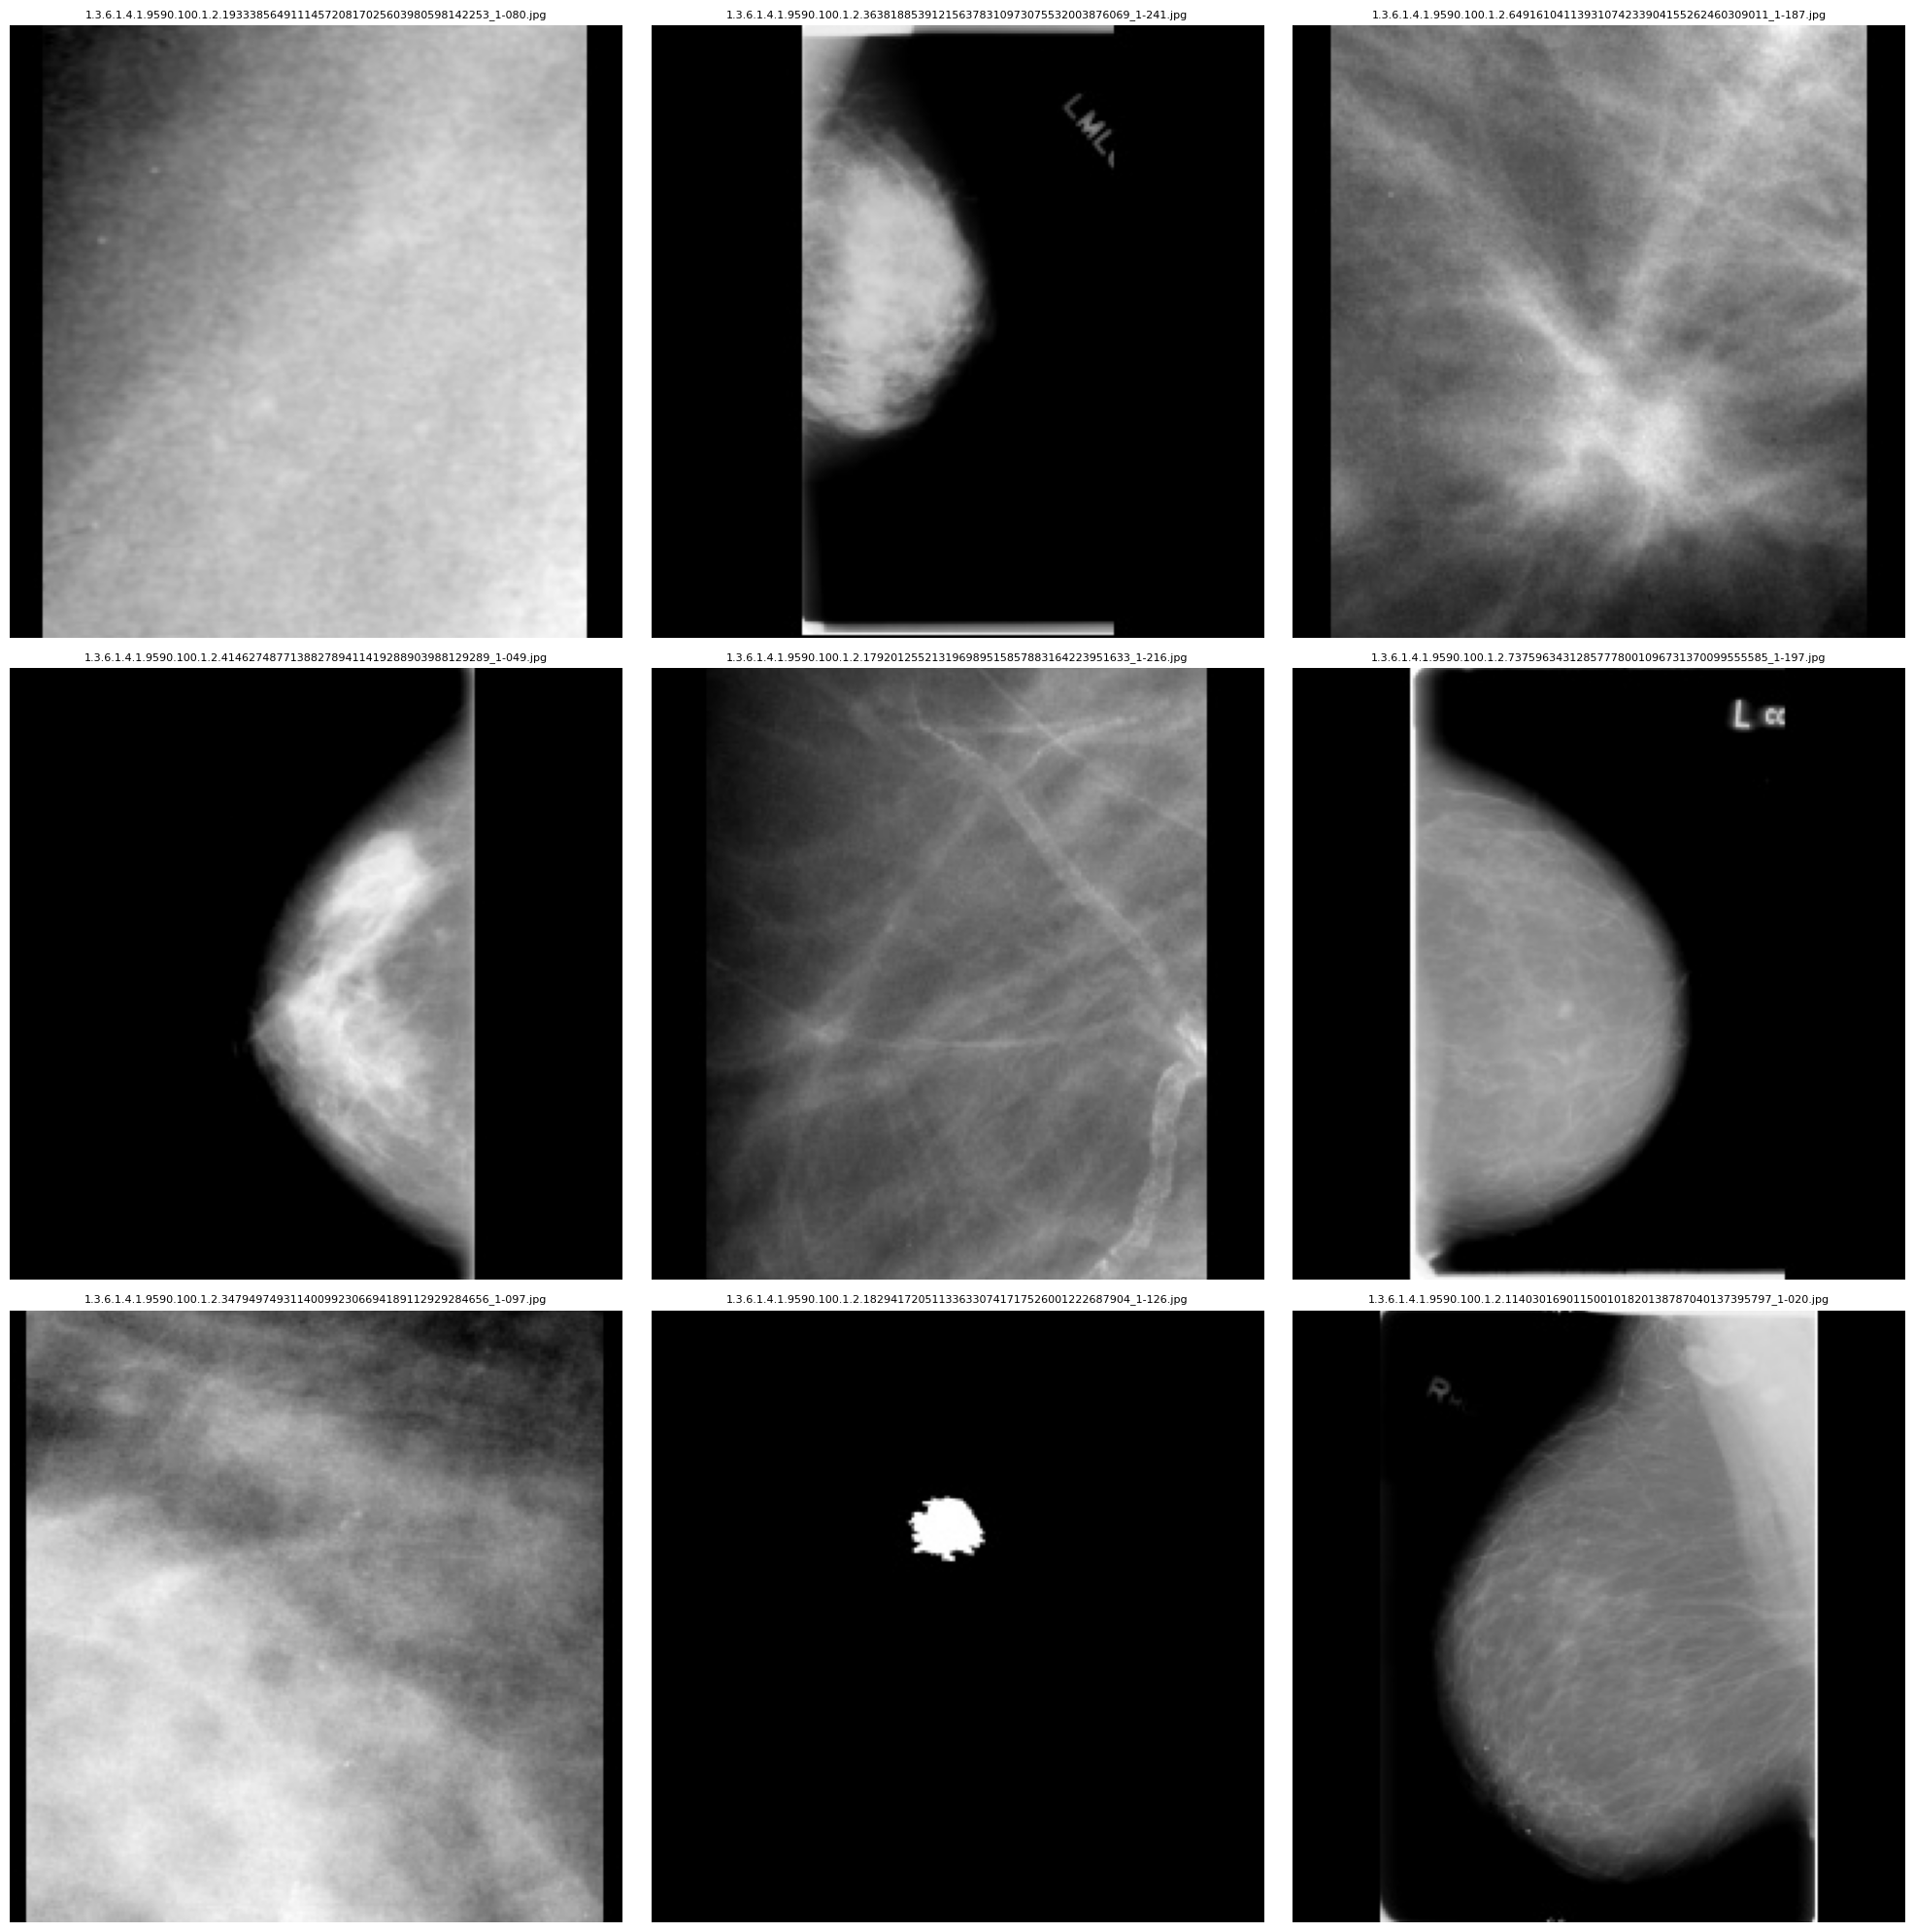

In [ ]:
# visualize the dataset
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_mammography_images(dataset_path, num_images=9):
    """
    Visualize mammography images from the dataset

    Parameters:
    -----------
    dataset_path : str
        Path to the main dataset folder
    num_images : int, optional
        Number of images to display (default: 9)
    """
    # Find all jpg files
    jpg_files = []
    for root, dirs, files in os.walk(dataset_path):
        jpg_files.extend([os.path.join(root, f) for f in files if f.lower().endswith('.jpg')])

    # Check if any images found
    if not jpg_files:
        print("No JPG images found in the dataset.")
        return

    # Determine grid layout
    grid_size = int(np.ceil(np.sqrt(num_images)))

    # Create figure
    plt.figure(figsize=(20, 20))

    # Randomly select images
    import random
    selected_images = random.sample(jpg_files, min(num_images, len(jpg_files)))

    # Plot images
    for i, image_path in enumerate(selected_images, 1):
        try:
            # Read image
            image = plt.imread(image_path)

            # Create subplot
            plt.subplot(grid_size, grid_size, i)

            # Handle different image types
            if len(image.shape) == 3:
                plt.imshow(image)
            else:
                plt.imshow(image, cmap='gray')

            plt.title(os.path.basename(image_path), fontsize=8)
            plt.axis('off')
        except Exception as e:
            print(f"Error reading image {image_path}: {e}")

    plt.tight_layout()
    plt.show()
visualize_mammography_images('//content/resized_mammograms_jpeg')


# 3. Data transformation

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torchvision import transforms
from PIL import Image

def resize_mammography_images(dataset_path, output_path, target_size=(224, 224), preserve_aspect_ratio=True,
                             save_transformed_tensors=False, tensor_output_path=None):
    """
    Resize all mammography images to a standard size for CNN processing

    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    if save_transformed_tensors and tensor_output_path:
        os.makedirs(tensor_output_path, exist_ok=True)

    # Define transform pipeline for PyTorch
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels if needed
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    # Find all jpg files
    jpg_files = []
    for root, dirs, files in os.walk(dataset_path):
        jpg_files.extend([os.path.join(root, f) for f in files if f.lower().endswith('.jpg')])

    # Check if any images found
    if not jpg_files:
        print("No JPG images found in the dataset.")
        return 0

    print(f"Found {len(jpg_files)} images to process.")

    # Process each image
    processed_count = 0
    for image_path in tqdm(jpg_files):
        try:
            # Create subdirectory structure in output folder
            rel_path = os.path.relpath(os.path.dirname(image_path), dataset_path)
            dest_folder = os.path.join(output_path, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            # Output path for this image
            output_file = os.path.join(dest_folder, os.path.basename(image_path))

            # Method 1: OpenCV resize for saved images
            if not save_transformed_tensors:
                # Read image with OpenCV
                image = cv2.imread(image_path)

                # Convert BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                if preserve_aspect_ratio:
                    # Get original dimensions
                    h, w = image.shape[:2]

                    # Calculate scaling factor
                    scale = min(target_size[1] / h, target_size[0] / w)

                    # Calculate new dimensions
                    new_h, new_w = int(h * scale), int(w * scale)

                    # Resize image while preserving aspect ratio
                    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

                    # Create blank canvas with target size
                    final_image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

                    # Calculate position to paste resized image (centered)
                    y_offset = (target_size[1] - new_h) // 2
                    x_offset = (target_size[0] - new_w) // 2

                    # Paste resized image onto canvas
                    final_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
                else:
                    # Directly resize to target size
                    final_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

                # Save file with same name
                cv2.imwrite(output_file, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

            # Method 2: PyTorch transforms for tensor processing
            if save_transformed_tensors:
                # Use PIL and PyTorch transforms
                pil_image = Image.open(image_path)

                # Apply transforms to get normalized tensor
                image_tensor = transform(pil_image)

                # If also saving resized images, save PIL resized version
                if not os.path.exists(output_file):
                    resized_pil = pil_image.resize(target_size)
                    resized_pil.save(output_file)

                # Determine tensor save path
                if tensor_output_path:
                    tensor_folder = os.path.join(tensor_output_path, rel_path)
                    os.makedirs(tensor_folder, exist_ok=True)
                    tensor_file = os.path.join(tensor_folder, os.path.splitext(os.path.basename(image_path))[0] + '.pt')

                    # Save tensor
                    torch.save(image_tensor, tensor_file)

            processed_count += 1
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    print(f"Successfully processed {processed_count} images. Saved to {output_path}")
    if save_transformed_tensors and tensor_output_path:
        print(f"Normalized tensors saved to {tensor_output_path}")

    return processed_count


# Just resize images
resize_mammography_images('/content/full_mammograms', '/content/resized_mammograms_jpeg')

# Resize images and save normalized tensors for direct CNN input
# resize_mammography_images('/content/jpeg', '/content/resized_jpeg', save_transformed_tensors=True, tensor_output_path='/content/tensors')



Found 6774 images to process.


100%|██████████| 6774/6774 [13:14<00:00,  8.53it/s]

Successfully processed 6774 images. Saved to /content/resized_mammograms_jpeg


6774

In [ ]:
def load_example_image(image_path, target_size=(224, 224)):
    """
    Load and transform a single image using PyTorch transforms

    Parameters:
    -----------
    image_path : str
        Path to the image
    target_size : tuple
        Size to resize the image to

    Returns:
    --------
    torch.Tensor
        Transformed image tensor ready for CNN input
    """
    # Define transform pipeline
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.Grayscale(num_output_channels=3),  # If necessary, make sure image has 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    # Load and transform the image
    image = Image.open(image_path)
    image_tensor = transform(image)

    return image_tensor

load_example_image("/content/jpeg/1.3.6.1.4.1.9590.100.1.2.100522099512256189513864912954167862869/1-231.jpg")

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2147, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.3936, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6051, 2.6400, 2.

In [ ]:
import os
import shutil
from tqdm import tqdm

def extract_full_mammograms(source_path, destination_path):
    """
    Extract only the first image (full mammogram) from each folder and save to a new directory.

    Parameters:
    -----------
    source_path : str
        Path to the main dataset folder containing subdirectories with mammogram images
    destination_path : str
        Path where the extracted full mammogram images will be saved

    Returns:
    --------
    int
        Number of full mammogram images extracted
    """
    # Ensure destination directory exists
    os.makedirs(destination_path, exist_ok=True)

    # Track count of extracted images
    extracted_count = 0

    # Find all subdirectories
    all_subdirs = []
    for root, dirs, files in os.walk(source_path):
        for directory in dirs:
            all_subdirs.append(os.path.join(root, directory))

    print(f"Found {len(all_subdirs)} folders to process.")

    # Process each subdirectory
    for subdir in tqdm(all_subdirs):
        try:
            # Get all image files in this subdirectory
            image_files = [f for f in os.listdir(subdir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            # Sort to ensure consistent ordering
            image_files.sort()

            # Skip if no images found
            if not image_files:
                continue

            # Get the first image (full mammogram)
            first_image = image_files[0]
            first_image_path = os.path.join(subdir, first_image)

            # Create relative path structure in destination
            rel_path = os.path.relpath(subdir, source_path)

            # Option 1: Maintain folder structure
            # dest_dir = os.path.join(destination_path, rel_path)
            # os.makedirs(dest_dir, exist_ok=True)
            # dest_file = os.path.join(dest_dir, first_image)

            # Option 2: Flatten structure but use folder name in filename
            folder_name = os.path.basename(subdir)
            new_filename = f"{folder_name}_{first_image}"
            dest_file = os.path.join(destination_path, new_filename)

            # Copy the file
            shutil.copy2(first_image_path, dest_file)
            extracted_count += 1

        except Exception as e:
            print(f"Error processing folder {subdir}: {e}")

    print(f"Successfully extracted {extracted_count} full mammogram images to {destination_path}")
    return extracted_count

# Example usage:
extract_full_mammograms('/content/jpeg', '/content/full_mammograms')

Found 6774 folders to process.


100%|██████████| 6774/6774 [00:47<00:00, 143.99it/s]

Successfully extracted 6774 full mammogram images to /content/full_mammograms


6774

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 2. Data Preprocessing

In [ ]:
import os
import numpy as np
from IPython import get_ipython

# ... (your other code) ...

def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    # Get the current working directory instead of using __file__
    notebook_dir = os.getcwd()

    # Construct the path to the data file relative to the current directory
    data_path = os.path.join(notebook_dir, 'breast_cancer', 'numpy data', 'train_tensor.npy')

    # Load the data
    images = np.load(data_path)[1::2]

    # Repeat the same logic for train_labels.npy
    data_path = os.path.join(notebook_dir, 'breast_cancer', 'numpy data', 'train_labels.npy')
    labels = np.load(data_path)[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    # Get the current working directory instead of using __file__
    notebook_dir = os.getcwd()

    # Construct the path to the data file relative to the current directory
    data_path = os.path.join(notebook_dir, 'breast_cancer', 'numpy data', 'public_test_tensor.npy')

    # Load the data
    images = np.load(data_path)[1::2]

    # Repeat the same logic for public_test_labels.npy
    data_path = os.path.join(notebook_dir, 'breast_cancer', 'numpy data', 'public_test_labels.npy')
    labels = np.load(data_path)[1::2]

    return images, labels

In [ ]:
import pandas as pd
cal_case_train = pd.read_csv('/content/csv/calc_case_description_test_set.csv')
cal_case_test = pd.read_csv('/content/csv/calc_case_description_train_set.csv')
mass_case_train = pd.read_csv('/content/csv/mass_case_description_test_set.csv')
mass_case_test = pd.read_csv('/content/csv/mass_case_description_train_set.csv')
dicom_data = pd.read_csv('/content/csv/dicom_info.csv')
meta = pd.read_csv('/content/csv/meta.csv')

In [ ]:
len(cal_case_test), len(cal_case_train), len(mass_case_test), len(mass_case_train),len(meta)

(1546, 326, 1318, 378, 6775)

In [ ]:
len(dicom_data)

10237

In [ ]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [ ]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [ ]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
print(cropped_images.head())
print(len(cropped_images))

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object
3567


In [ ]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', 'jpeg'))
cropped_images.head()

,image_path
0,jpeg/1.3.6.1.4.1.9590.100.1.2.1293087268128519...
3,jpeg/1.3.6.1.4.1.9590.100.1.2.3811873696115245...
6,jpeg/1.3.6.1.4.1.9590.100.1.2.1533390529131213...
7,jpeg/1.3.6.1.4.1.9590.100.1.2.1789947146114851...
10,jpeg/1.3.6.1.4.1.9590.100.1.2.4118334926123736...


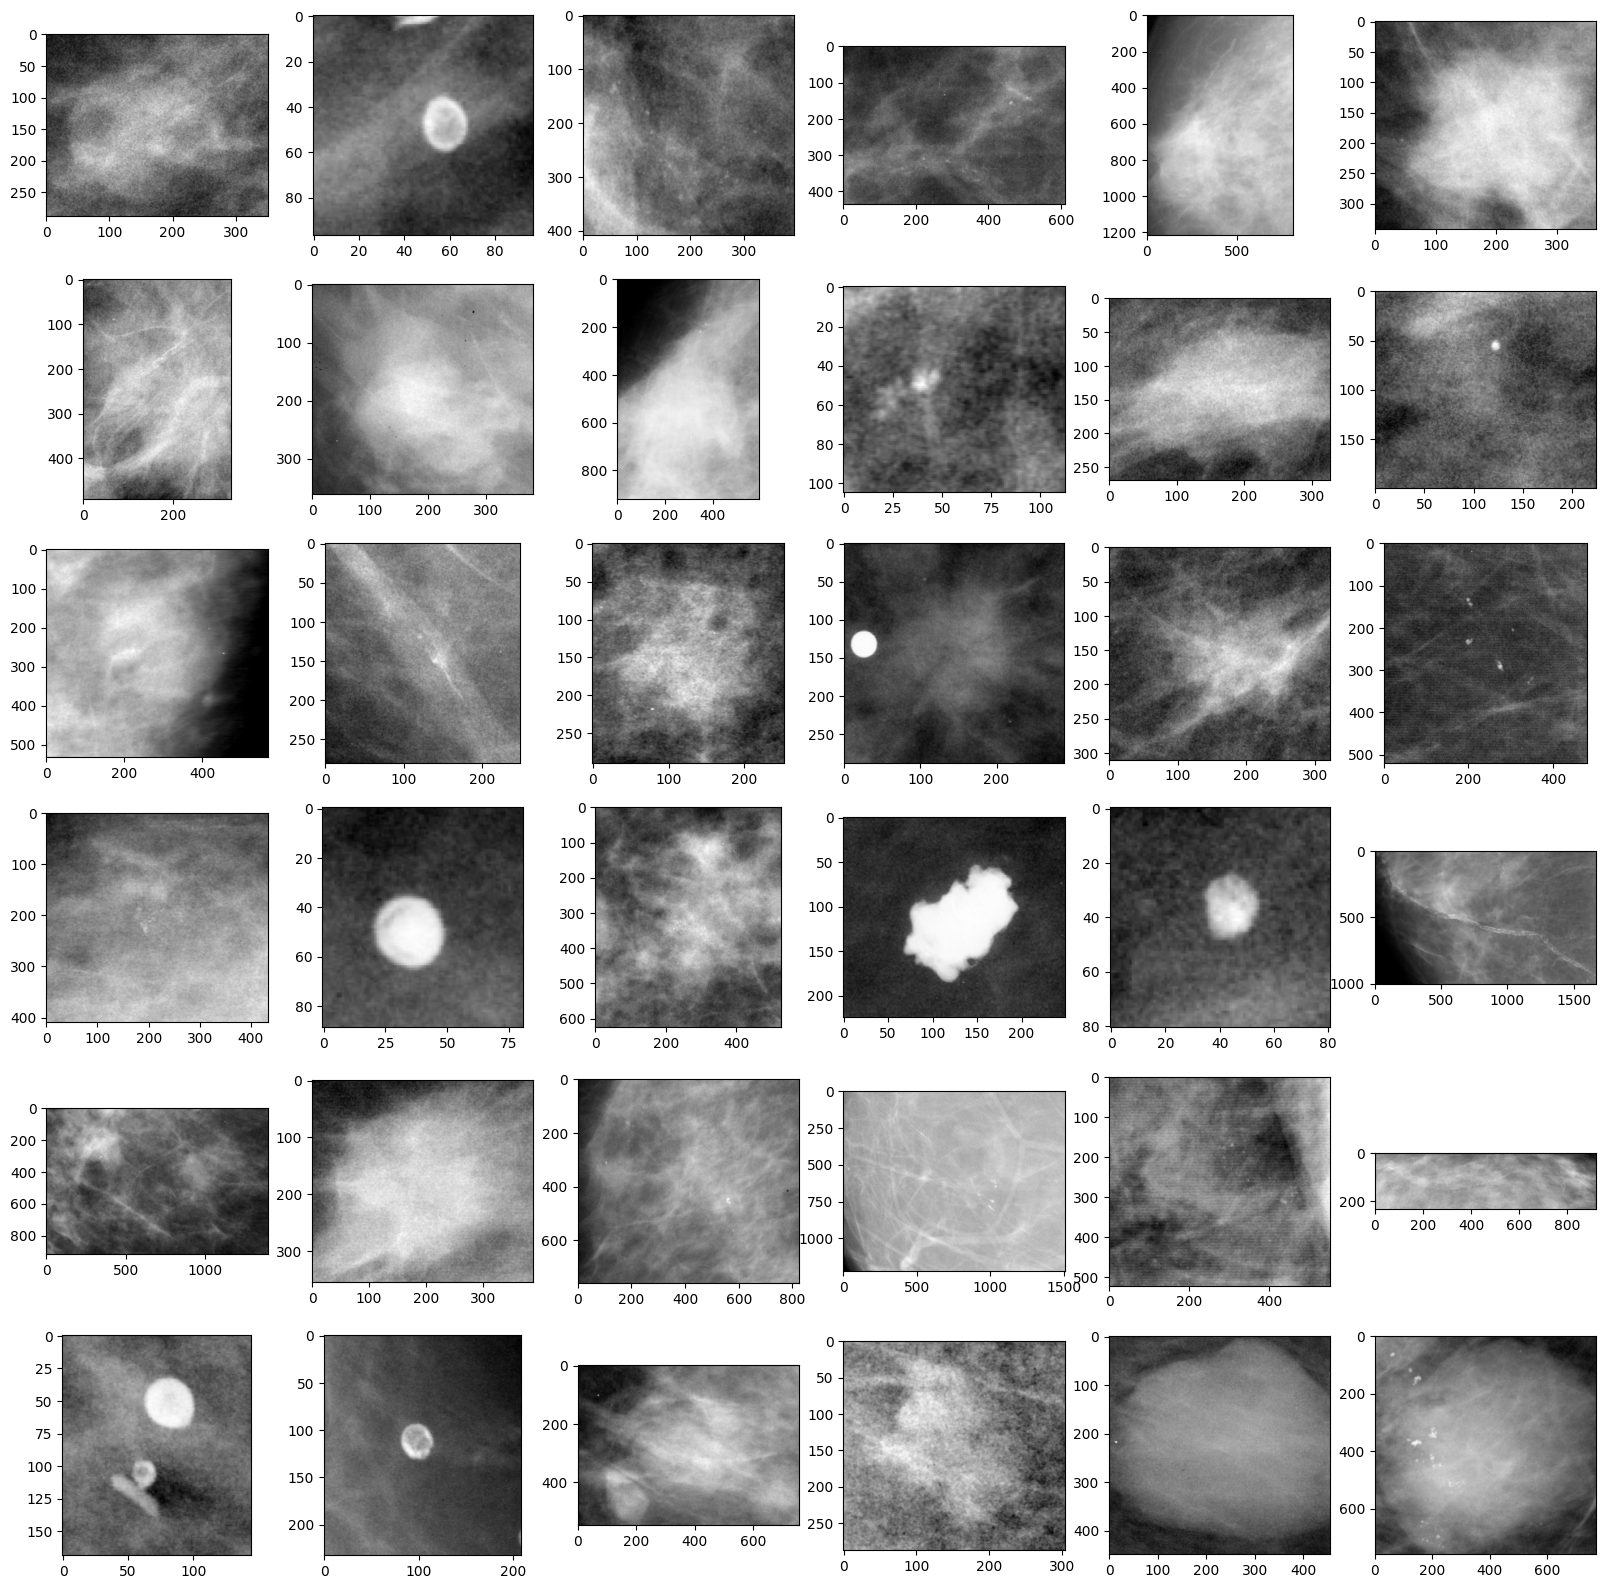

In [ ]:
import PIL
import random
import matplotlib.pyplot as plt


num_images_to_display = min(36, len(cropped_images))

plt.figure(figsize=(20, 20))

for i, image_path in enumerate(cropped_images[:num_images_to_display], 1):
    image = plt.imread(image_path)
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='gray')

plt.show()

In [ ]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

,image_path
1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...


In [ ]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', 'jpeg'))
full_mammogram_images.head()

,image_path
1,jpeg/1.3.6.1.4.1.9590.100.1.2.2483867420106785...
2,jpeg/1.3.6.1.4.1.9590.100.1.2.2672131710111718...
11,jpeg/1.3.6.1.4.1.9590.100.1.2.2103968939112343...
12,jpeg/1.3.6.1.4.1.9590.100.1.2.7495665831138395...
15,jpeg/1.3.6.1.4.1.9590.100.1.2.9876588541294641...


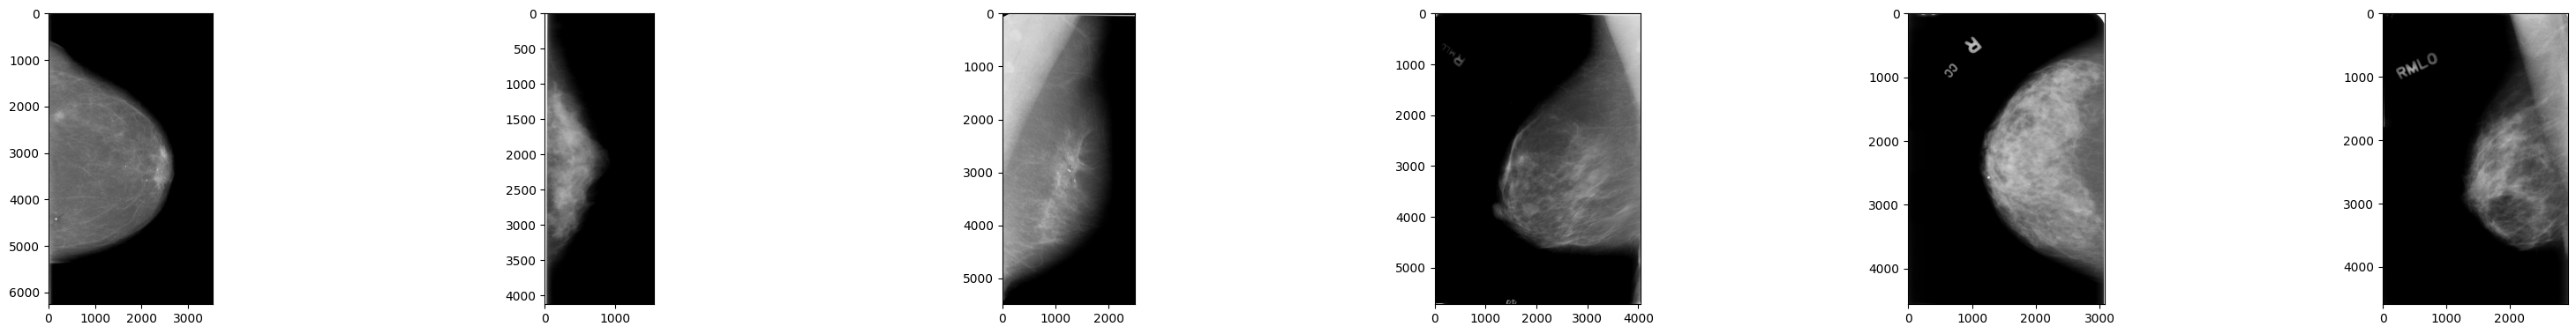

In [ ]:
num_images_to_display = min(6, len(full_mammogram_images))

plt.figure(figsize=(40,30))

for i, image_path in enumerate(full_mammogram_images[:num_images_to_display], 1):
    image = plt.imread(image_path)
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='gray')

plt.show()

In [ ]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

,image_path
5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...


In [ ]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', 'jpeg'))
ROI_mask_images.head()

,image_path
5,jpeg/1.3.6.1.4.1.9590.100.1.2.1533390529131213...
8,jpeg/1.3.6.1.4.1.9590.100.1.2.1789947146114851...
9,jpeg/1.3.6.1.4.1.9590.100.1.2.4118334926123736...
14,jpeg/1.3.6.1.4.1.9590.100.1.2.2363735487129941...
20,jpeg/1.3.6.1.4.1.9590.100.1.2.3570080504125347...


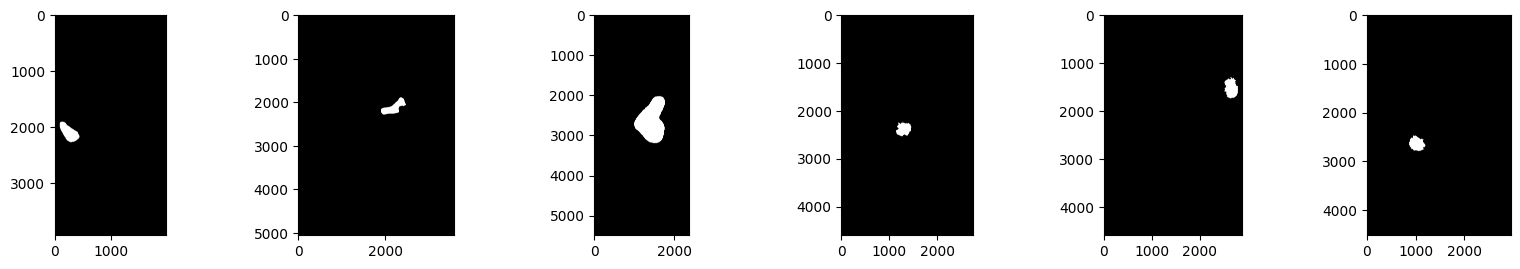

In [ ]:
num_images_to_display = min(6, len(ROI_mask_images))

plt.figure(figsize=(20,20))

for i, image_path in enumerate(ROI_mask_images[:num_images_to_display], 1):
    image = plt.imread(image_path)
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='gray')

plt.show()

In [ ]:
cal_case_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               326 non-null    object
 1   breast density           326 non-null    int64 
 2   left or right breast     326 non-null    object
 3   image view               326 non-null    object
 4   abnormality id           326 non-null    int64 
 5   abnormality type         326 non-null    object
 6   calc type                322 non-null    object
 7   calc distribution        263 non-null    object
 8   assessment               326 non-null    int64 
 9   pathology                326 non-null    object
 10  subtlety                 326 non-null    int64 
 11  image file path          326 non-null    object
 12  cropped image file path  326 non-null    object
 13  ROI mask file path       326 non-null    object
dtypes: int64(4), object(10)
memory usage: 35.8

In [ ]:
cal_case_train.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


In [ ]:
mass_case_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [ ]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [ ]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)

In [ ]:
dicom_cleaned_data.isna().sum()

,0
file_path,0
image_path,0
BitsAllocated,0
BitsStored,0
BodyPartExamined,0
ConversionType,0
HighBit,0
LargestImagePixelValue,0
Laterality,566
Modality,0


In [ ]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

<ipython-input-23-51dfb01b4b86>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-23-51dfb01b4b86>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)


In [ ]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

<ipython-input-24-82d3dade18f9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-24-82d3dade18f9>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)


In [ ]:
dicom_cleaned_data.isna().sum()

,0
file_path,0
image_path,0
BitsAllocated,0
BitsStored,0
BodyPartExamined,0
ConversionType,0
HighBit,0
LargestImagePixelValue,0
Laterality,0
Modality,0


In [ ]:
import pandas as pd

def rename_columns(calc_case_df: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the DataFrame to avoid modifying the original one
    Data_cleaning_1 = calc_case_df.copy()

    # Rename columns
    column_renames = {
        'calc type': 'calc_type',
        'calc distribution': 'calc_distribution',
        'image view': 'image_view',
        'left or right breast': 'left_or_right_breast',
        'breast density': 'breast_density',
        'abnormality type': 'abnormality_type'
    }

    # Rename the columns based on the dictionary
    Data_cleaning_1 = Data_cleaning_1.rename(columns=column_renames)

    return Data_cleaning_1
cal_case_train = rename_columns(
    cal_case_train
)

In [ ]:
def convert_to_category(calc_case_df: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the DataFrame to avoid modifying the original one
    Data_cleaning_1 = calc_case_df.copy()

    # Convert relevant columns to 'category' dtype
    categorical_columns = [
        'pathology',
        'calc_type',
        'calc_distribution',
        'abnormality_type',
        'image_view',
        'left_or_right_breast'
    ]

    for col in categorical_columns:
        if col in Data_cleaning_1.columns:
            Data_cleaning_1[col] = Data_cleaning_1[col].astype('category')

    return Data_cleaning_1
cal_case_train = convert_to_category(cal_case_train)

In [ ]:
cal_case_train.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
calc_type,4
calc_distribution,63
assessment,0
pathology,0


In [ ]:
cal_case_train['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
cal_case_train['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
cal_case_train.isna().sum()

<ipython-input-29-ac7cb36dfa6e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_case_train['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-29-ac7cb36dfa6e>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cal_case_train['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-29-ac7cb36dfa6e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chaine

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
calc_type,0
calc_distribution,0
assessment,0
pathology,0


In [ ]:
def rename_columns_mass(mass_case_df: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the DataFrame to avoid modifying the original one
    Data_cleaning_2 = mass_case_df.copy()

    # Rename columns
    column_renames = {
        'mass shape': 'mass_shape',
        'left or right breast': 'left_or_right_breast',
        'mass margins': 'mass_margins',
        'image view': 'image_view',
        'abnormality type': 'abnormality_type'
    }

    # Rename the columns based on the dictionary
    Data_cleaning_2 = Data_cleaning_2.rename(columns=column_renames)

    return Data_cleaning_2

mass_case_train = rename_columns_mass(mass_case_train)

In [ ]:
def convert_to_category_mass(mass_case_df: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the DataFrame to avoid modifying the original one
    Data_cleaning_2 = mass_case_df.copy()

    # Convert relevant columns to 'category' dtype
    categorical_columns = [
        'pathology',
        'mass_shape',
        'left_or_right_breast',
        'image_view',
        'mass_margins',
        'abnormality_type'
    ]

    for col in categorical_columns:
        if col in Data_cleaning_2.columns:
            Data_cleaning_2[col] = Data_cleaning_2[col].astype('category')

    return Data_cleaning_2

mass_case_train = convert_to_category_mass(mass_case_train)

In [ ]:
mass_case_train.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
mass_shape,0
mass_margins,17
assessment,0
pathology,0


In [ ]:
mass_case_train['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
mass_case_train.isna().sum()

<ipython-input-33-8d5546499146>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mass_case_train['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-33-8d5546499146>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mass_case_train['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)


,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [ ]:
def load_training(df):
    """
    Load the training set (excluding baseline patches)
    """

    images = os.path('jpeg')

In [ ]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

In [ ]:
df = pd.concat([cal_case_train, mass_case_train,cal_case_test,mass_case_test], axis=0)

In [ ]:
len(df)

3568

In [ ]:
# Iterate through the dataset and load each image along with its label
images = []
labels = []
for index, row in dicom_data.iterrows():
  full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path

    image_path = row['image file path']
    label = row['pathology']

    # Load the full image
    image = load_image(image_path)

    # If image is successfully loaded, append to the list
    if image is not None:
        images.append(image)
        labels.append(label)

In [ ]:
images = []
cropped_images = []
roi_masks = []
full_images = []
for index, row in dicom_data.iterrows():
    if row['SeriesDescription'] == 'full mammogram images':
        # Full mammogram image path
        full_mammogram_image_path = row['image_path']
        full_mammogram_image_path = full_mammogram_image_path.replace('CBIS-DDSM/jpeg', 'jpeg')  # Adjust path

    if row['SeriesDescription'] == 'cropped images':   # Cropped image path
        cropped_image_path = row['image_path']
        cropped_image_path = cropped_image_path.replace('CBIS-DDSM/jpeg', 'jpeg')  # Adjust path

    if row['SeriesDescription'] == 'ROI mask images':
        # ROI mask image path
        roi_mask_path = row['image_path']
        roi_mask_path = roi_mask_path.replace('CBIS-DDSM/jpeg', 'jpeg')  # Adjust path

         # Append the paths and labels to their respective lists
        images.append(full_mammogram_image_path)
        cropped_images.append(cropped_image_path)
        roi_masks.append(roi_mask_path)
        full_images.append([full_mammogram_image_path,cropped_image_path,roi_mask_path])

print(len(images))
print(len(cropped_images))
print(len(roi_masks))
print(len(full_images))

3247
3247
3247
3247


In [ ]:

dicom_data['image_path'] = dicom_data['image_path'].apply(lambda x: x.replace('CBIS-DDSM/jpeg', 'jpeg'))

images_path  = dicom_data['image_path']

In [ ]:
len(images_path)

10237

In [ ]:
labels = {}
def add_labels(df,labels):
  for index, row in df.iterrows():
    # Use row['image file path'] to get the actual image path string
    image_path = row['image file path']
    label = row['pathology']

    # If the image_path is already in the dictionary, append the new label
    if image_path in labels:
        labels[image_path].append(label)
    else:
        # If it's the first time we encounter this image path, add it with the label
        labels[image_path] = [label]
  return labels

In [ ]:
image_labels = add_labels(cal_case_train,labels)

In [ ]:
len(image_labels)

284

In [ ]:
cal_case_train.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality id,abnormality_type,calc_type,calc_distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,CLUSTERED,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,CLUSTERED,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,CLUSTERED,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


In [ ]:
import pandas as pd
import os
import shutil
from tqdm import tqdm
import numpy as np
import cv2

import pandas as pd
import os
import shutil
from tqdm import tqdm
import numpy as np
import cv2

images = []
cropped_images = []
roi_masks = []
labels = []

# Iterate over the rows of the dataset (dicom_data)
for index, row in dicom_data.iterrows():
    if row['SeriesDescription'] == 'full mammogram images':
        # Full mammogram image path
        full_mammogram_image_path = row['image_path']
        full_mammogram_image_path = full_mammogram_image_path.replace('CBIS-DDSM/jpeg', 'jpeg')  # Adjust path

    if row['SeriesDescription'] == 'cropped images':   # Cropped image path
        cropped_image_path = row['image_path']
        cropped_image_path = cropped_image_path.replace('CBIS-DDSM/jpeg', 'jpeg')  # Adjust path

    if row['SeriesDescription'] == 'ROI mask images':
        # ROI mask image path
        roi_mask_path = row['image_path']
        roi_mask_path = roi_mask_path.replace('CBIS-DDSM/jpeg', 'jpeg')  # Adjust path

        # Pathology label (assuming the column name is 'Pathology')
        pathology_label = row['Pathology']
        label = 0 if pathology_label.lower() == 'benign' else 1  # Convert benign to 0, malignant to 1

        # Append the paths and labels to their respective lists
        images.append(full_mammogram_image_path)
        cropped_images.append(cropped_image_path)
        roi_masks.append(roi_mask_path)
        labels.append(label)

# Check how many full images were found
print(f"Total full mammogram images: {len(images)}")

# Optional: Verify a few examples (first 3) to ensure correct paths
for i in range(3):
    print(f"Full Image Path: {images[i]}, Cropped Image Path: {cropped_images[i]}, ROI Mask Path: {roi_masks[i]}, Label: {labels[i]}")


KeyError: 'Pathology'

In [ ]:
dicom_data.sample(5)
dicom_data.iloc[2]

,2
file_path,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...
image_path,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
AccessionNumber,NaN
BitsAllocated,16
BitsStored,16
BodyPartExamined,BREAST
Columns,1546
ContentDate,20160503
ContentTime,111956.298
ConversionType,WSD


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torchvision import transforms
from PIL import Image

def resize_mammography_images(dataset_path, output_path, target_size=(224, 224), preserve_aspect_ratio=True,
                             save_transformed_tensors=False, tensor_output_path=None):
    """
    Resize all mammography images to a standard size for CNN processing

    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    if save_transformed_tensors and tensor_output_path:
        os.makedirs(tensor_output_path, exist_ok=True)

    # Define transform pipeline for PyTorch
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels if needed
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    # Find all jpg files
    jpg_files = []
    for root, dirs, files in os.walk('/content/breast_cancer_detection/datasets/CBIS-DDSM/jpeg'):
        jpg_files.extend([os.path.join(root, f) for f in files if f.lower().endswith('.jpg')])

    # Check if any images found
    if not jpg_files:
        print("No JPG images found in the dataset.")
        return 0

    print(f"Found {len(jpg_files)} images to process.")

    # Process each image
    processed_count = 0
    for image_path in tqdm(jpg_files):
        try:
            # Create subdirectory structure in output folder
            rel_path = os.path.relpath(os.path.dirname(image_path), dataset_path)
            dest_folder = os.path.join(output_path, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            # Output path for this image
            output_file = os.path.join(dest_folder, os.path.basename(image_path))

            # Method 1: OpenCV resize for saved images
            if not save_transformed_tensors:
                # Read image with OpenCV
                image = cv2.imread(image_path)

                # Convert BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                if preserve_aspect_ratio:
                    # Get original dimensions
                    h, w = image.shape[:2]

                    # Calculate scaling factor
                    scale = min(target_size[1] / h, target_size[0] / w)

                    # Calculate new dimensions
                    new_h, new_w = int(h * scale), int(w * scale)

                    # Resize image while preserving aspect ratio
                    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

                    # Create blank canvas with target size
                    final_image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

                    # Calculate position to paste resized image (centered)
                    y_offset = (target_size[1] - new_h) // 2
                    x_offset = (target_size[0] - new_w) // 2

                    # Paste resized image onto canvas
                    final_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
                else:
                    # Directly resize to target size
                    final_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

                # Save file with same name
                cv2.imwrite(output_file, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

            # Method 2: PyTorch transforms for tensor processing
            if save_transformed_tensors:
                # Use PIL and PyTorch transforms
                pil_image = Image.open(image_path)

                # Apply transforms to get normalized tensor
                image_tensor = transform(pil_image)

                # If also saving resized images, save PIL resized version
                if not os.path.exists(output_file):
                    resized_pil = pil_image.resize(target_size)
                    resized_pil.save(output_file)

                # Determine tensor save path
                if tensor_output_path:
                    tensor_folder = os.path.join(tensor_output_path, rel_path)
                    os.makedirs(tensor_folder, exist_ok=True)
                    tensor_file = os.path.join(tensor_folder, os.path.splitext(os.path.basename(image_path))[0] + '.pt')

                    # Save tensor
                    torch.save(image_tensor, tensor_file)

            processed_count += 1
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    print(f"Successfully processed {processed_count} images. Saved to {output_path}")
    if save_transformed_tensors and tensor_output_path:
        print(f"Normalized tensors saved to {tensor_output_path}")

    return processed_count


# Just resize images
#resize_mammography_images('/content/full_mammograms', '/content/resized_mammograms_jpeg')

#dataset_path = full_dataset[full_dataset["image_file_path"].notna()]['image_file_path']
# Resize images and save normalized tensors for direct CNN input
resize_mammography_images('/content/breast_cancer_detection/datasets/CBIS-DDSM/jpeg', '/content/resized_jpeg', save_transformed_tensors=True, tensor_output_path='/content/image_tensors')



In [ ]:
def split_dataset(dataframe, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, stratify=True):
    """
    Split dataset into train, validation, and test sets.

    Args:
        dataframe: DataFrame containing image paths and labels
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data
        test_ratio: Ratio of test data
        stratify: Whether to stratify the split based on labels

    Returns:
        train_df, val_df, test_df
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    if stratify:
        # Stratified split
        train_dfs = []
        val_dfs = []
        test_dfs = []

        # Split for each class
        for label in [0, 1]:  # Benign (0) and Malignant (1)
            class_df = dataframe[dataframe['label'] == label]

            # Calculate split sizes
            n_total = len(class_df)
            n_train = int(n_total * train_ratio)
            n_val = int(n_total * val_ratio)
            n_test = n_total - n_train - n_val

            # Random shuffle
            shuffled_df = class_df.sample(frac=1, random_state=42).reset_index(drop=True)

            # Split
            train_dfs.append(shuffled_df.iloc[:n_train])
            val_dfs.append(shuffled_df.iloc[n_train:n_train + n_val])
            test_dfs.append(shuffled_df.iloc[n_train + n_val:])

        # Combine splits from each class
        train_df = pd.concat(train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
        val_df = pd.concat(val_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
        test_df = pd.concat(test_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        # Random split (not stratified)
        shuffled_df = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

        # Calculate split sizes
        n_total = len(shuffled_df)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        # Split
        train_df = shuffled_df.iloc[:n_train]
        val_df = shuffled_df.iloc[n_train:n_train + n_val]
        test_df = shuffled_df.iloc[n_train + n_val:]

    # Print split statistics
    print("\nDataset Split Statistics:")
    print(f"Total samples: {len(dataframe)}")
    print(f"Training: {len(train_df)} samples ({train_ratio*100:.1f}%)")
    print(f"  Benign: {len(train_df[train_df['label'] == 0])}")
    print(f"  Malignant: {len(train_df[train_df['label'] == 1])}")
    print(f"Validation: {len(val_df)} samples ({val_ratio*100:.1f}%)")
    print(f"  Benign: {len(val_df[val_df['label'] == 0])}")
    print(f"  Malignant: {len(val_df[val_df['label'] == 1])}")
    print(f"Test: {len(test_df)} samples ({test_ratio*100:.1f}%)")
    print(f"  Benign: {len(test_df[test_df['label'] == 0])}")
    print(f"  Malignant: {len(test_df[test_df['label'] == 1])}")

    return train_df, val_df, test_df




In [ ]:
def save_split_datasets(train_df, val_df, test_df, output_dir):
    """Save the split datasets to CSV files."""
    os.makedirs(output_dir, exist_ok=True)

    train_df.to_csv(os.path.join(output_dir, 'train_dataset.csv'), index=False)
    val_df.to_csv(os.path.join(output_dir, 'val_dataset.csv'), index=False)
    test_df.to_csv(os.path.join(output_dir, 'test_dataset.csv'), index=False)

    # Create a combined CSV with a 'split' column
    train_df['split'] = 'train'
    val_df['split'] = 'val'
    test_df['split'] = 'test'

    combined_df = pd.concat([train_df, val_df, test_df])
    combined_df.to_csv(os.path.join(output_dir, 'full_dataset_with_splits.csv'), index=False)

    print(f"\nDataset splits saved to {output_dir}")

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import pathlib

class MammogramDataset(Dataset):
    """Custom dataset for mammogram images."""
    def __init__(self, dataframe, tensor_dir, transform=None):
        """
        Args:
            dataframe: DataFrame containing image paths and labels
            tensor_dir: Directory to save/load tensors
            image_type: Type of image to use ('full_images', 'cropped_images', or 'roi_masks')
            transform: Optional transforms to apply to images
        """
        self.dataframe = dataframe
        self.tensor_dir = tensor_dir
        self.transform = transform



        # Create tensor directory if it doesn't exist
        os.makedirs(tensor_dir, exist_ok=True)

        # Create subdirectories for classes
        for class_label in [0, 1]:  # Benign (0) and Malignant (1)
            os.makedirs(os.path.join(tensor_dir, str(class_label)), exist_ok=True)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_file_path']
        label = row['labels'] # Use the 'labels' column instead of 'pathology'

        # Handle missing image paths
        if image_path is None:
            print(f"Warning: Missing image path at index {idx}. Returning placeholder tensor.")
            return {
                'image': torch.zeros((3, 224, 224)), # Placeholder tensor
                'label': torch.tensor(label, dtype=torch.long),
                'tensor_path': None,  # Indicate missing path
                'original_path': None
            }

        # Generate tensor path
        image_filename = os.path.basename(image_path)
        tensor_filename = os.path.splitext(image_filename)[0] + '.pt'
        tensor_path = os.path.join(self.tensor_dir, str(label), tensor_filename)

        # Load or create tensor
        if os.path.exists(tensor_path):
            # Load existing tensor
            tensor = torch.load(tensor_path)
        else:
            # Convert image to tensor and save
            try:
                image = Image.open(image_path).convert('RGB')

                if self.transform:
                    tensor = self.transform(image)
                else:
                    # Default transform if none provided
                    tensor = transforms.ToTensor()(image)

                # Save tensor
                torch.save(tensor, tensor_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                # Return a placeholder tensor if image loading fails
                tensor = torch.zeros((3, 224, 224))

        return {
            'image': tensor,
            'label': torch.tensor(label, dtype=torch.long), # Now label is a numerical value (0 or 1)
            'tensor_path': tensor_path,
            'original_path': image_path
        }

In [ ]:
# Path to your dataset CSV file (adjust as needed)
dataset_path = 'mammogram_dataset_metadata.csv'

# Base directories for tensors and output
tensor_base_dir = 'mammogram_tensors'
output_dir = 'mammogram_dataset_splits'

# Load dataset
print(f"Loading dataset from {dataset_path}...")
mammogram_df = full_dataset_train

# Display dataset info
print(f"Dataset loaded: {len(mammogram_df)} samples")
print(f"Class distribution:\n{mammogram_df['pathology'].value_counts()}")

# Convert images to tensors (choose which image types to convert)
image_types_to_convert = ['cropped_images']  # Add 'full_images' and/or 'roi_masks' as needed

# Convert images to tensors and update dataframe
updated_df = convert_dataset_to_tensors(
    dataframe=mammogram_df,
    base_dir=tensor_base_dir,
    img_size=224,  # Adjust based on your model needs
    batch_size=32
)

# Split dataset
train_df, val_df, test_df = split_dataset(
    dataframe=updated_df,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    stratify=True  # Set to True for stratified splitting
)

# Save splits
save_split_datasets(train_df, val_df, test_df, output_dir)

print("\nDataset preparation complete!")